# 机器学习算法性能比对分析流程

写这篇文章的初衷是受到优达学城“机器学习纳米学位（进阶）”课程中“finding donors”项目的启发。主要是梳理比对不同的机器学习算法的流程。

本文章使用的数据集是“Census Income Data Set”，来自[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income)。我们的目标是使用多种机器学习算法预测收入，具体来说，预测一个人的收入是否超过50000美金.

本文所有代码均在jupyter notebook上运行通过，使用的python版本是2.7.14，[源代码点击这里](https://github.com/freefrog1986/ML-master-udacity/tree/master/3.%20Supervised%20Learning/finding_donors)。

## 目录

1. 探索数据
2. 准备数据
3. 评估模型性能
4. 改进结果
5. 特征重要性
6. 特征选择

## 1. 探索数据

首先，读入需要的库。numpy用于处理运算，pandas用于处理数据，time用于计算运行时间，display用于更好的显示图片。

In [6]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


首先我们读入了数据集并显示前三行，这个数据集有不同类型的特征值，有连续值例如age，也有离散值例如workclass。

### 1.1 数据初探

我们的目标是预测收入，也就是数据集中的income变量。下面先看一看income变量的大概情况。

In [7]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
#n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
#n_at_most_50k = sum(data['income'] == '<=50K')
n_at_most_50k, n_greater_50k = data.income.value_counts()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = np.true_divide(n_greater_50k , n_records) * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


income只有两类，大于\$50000和小于\$50000，数据值一共有45222个样本，我们想要预测的数据（大于\$50000）占24.78%。
注意这里可以使用`.value_counts()`属性得到某一特征不同类别的数量。
另外值得注意的是，python中使用除法要非常小心，最好使用`np.true_divide()`来进行传统意义上的除法运算。

## 2. 准备数据

在使用数据之前，通常要经过清理、格式化和重组等步骤——这通常被称为预处理。幸运的是，这个数据集没有无效或丢失的样本。但是，需要对某些特征进行调整。这种预处理对几乎所有学习算法都有很大的帮助。

### 2.1 转换偏差的数值特征

首先我们来看一下如何处理数值特征，这类数据最容易出现的问题之一就是分布的偏差和方差过大，也就是说当大部分数据分布在一个固定值周围时，也会出现很多特别大或者特别小的值。
对于我们要处理的数据集来说`capital-gain`和`capital-loss`就是这样的特征。我们来画图看一下这两个特征的分布情况。

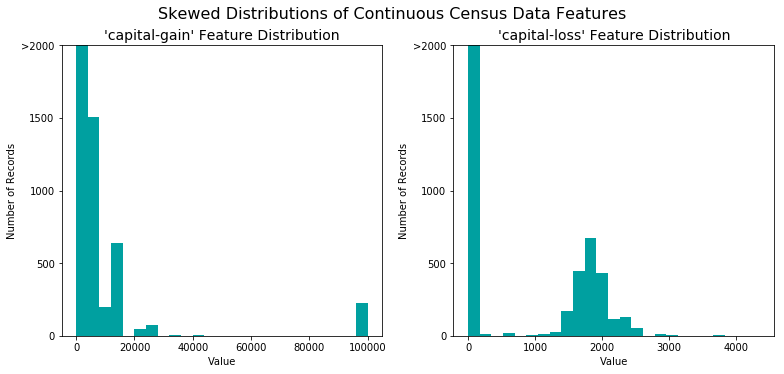

In [17]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

我们发现，对于`'capital-gain'`，大部分值分布在0-20000范围内，也有一些值分布在100000附近。而对于`'capital-loss'`，大部分数值分布在2000附近，另外有很大一部分数值分布在0附近，这种数据分布我们称为‘偏差’。另外，我们观察数值的分布范围，`'capital-gain'`是\[0, 100000\]， 而`'capital-loss'`是\[0, 4000\]，取值范围很大。

对于高度偏差的特征分布，如`'capital-gain'`和`'capital-loss'`，应用对数变换是很常见的做法，这样，非常大和非常小的值就不会对算法的性能产生负面影响。使用对数变换大大缩小了数值的范围。但是，在应用这种转换时必须注意：0的对数是未定义的，因此我们必须将数值转换成大于0的值。
运行下面的代码，对数据进行转换并可视化结果。同样，请注意数值的范围及分布。

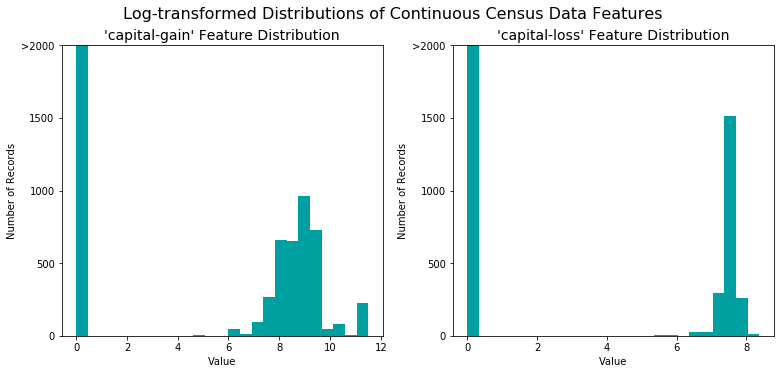

In [14]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

代码首先将数据转换为`pandas.Dataframe`类型，然后将特征的取值加1后取对数，加1的作用是避免出现0值。我们发现，转换后的分布由原来的很大的取值区间转换为现在的\[0, 12\].

### 2.2 连续特征正则化

除了在高度偏差的特性上执行转换之外，在数值特征上执行某种类型的缩放也是很好的做法。缩放操作不改变特征的分布（如上面的`'capital-gain”`或` 'capital-loss”`）；然而，正则化确保平等对待每个特征。需要注意的是，一旦进行缩放，其原始形式的数据的含义将改变（例如0.301370显然不是这个人的真实年龄），见下面的例子。

In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


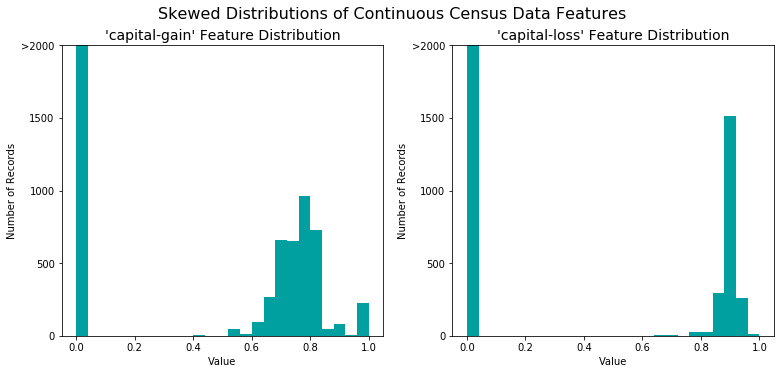

In [16]:
vs.distribution(features_log_minmax_transform)

观察结果，所有连续特征均被转换到\[0,1\]区间。   
总结以上步骤：

1. 观察所有数值特征
2. 对高偏差的特征进行对数转换
3. 对所有数值特征进行正则化

### 2.3 数据预处理

接下来我们来考虑离非数值征值，当然，我们需要将其转换为数值特征。一种常用的方法是使用**one-hot编码**。One-hot编码为非数值特征的每一种可能创建一个_"dummy"_ 变量. 例如, 假设 `someFeature` 有三种可能的取值: `A`, `B`, 或 `C`. 我们可以将其编码为`someFeature_A`, `someFeature_B` 和 `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot 编码 ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

同样，我们也需要对标签`'income'`进行转换。由于我们的标签只有两种取值("<=50K" and ">50K"), 我们可以不使用one-hot编码，而是直接使用`0`或`1`分别代表. 

下面是实战代码

In [20]:
from sklearn.preprocessing import LabelEncoder
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
encoder = LabelEncoder()
income = encoder.fit_transform(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


这里主要使用了`pd.get_dummies()`和`LabelEncoder().fit_transform()`，前者是将非数值特征进行one-hot编码，后者是将标签特征进行0,1编码

### 2.4 数据集划分

现在所有特征均被转换为数值并进行了归一化处理。接下来我们将数据集划分为训练集和测试集。

In [22]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 3. 评估模型性能

在这一节，我们将探索4个不同的分类器, 并决定哪一个最适合我们的数据. 其中，我们首先打造一个*朴素分类器*作为比对基准.

### 3.1 测量指标和朴素分类器

我们使用的测量指标是准确率（accuracy）和F-beta得分。   
观察标签数据的分布不难发现，大部分人的收入没有超过\$50,000. 这种情况很容易影响准确率（accuracy）。假设我们简单的认为所有人的收入都不超过$50,000,这样的一个**朴素分类器**也会有很好的准确率！   
接下来我们就先来打造这个朴素分类器。

In [23]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
TP = np.sum(income)
FP = len(income) - TP

accuracy = np.true_divide(TP,TP + FP)
recall = 1
precision = accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
fscore = (1 + 0.5**2) * (precision * recall) / ((0.5**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


如果读者不熟悉这里使用的测量指标，可以参考[这篇文章](https://zhuanlan.zhihu.com/p/31832769/edit)。我们发现，即便是这样一个简单的模型，也可以得到准确率0.2478。

### 3.2 模型选择

接下来就是模型选择了，一般来说使用选择模型从以下几方面考虑：数据量大小，特征值特点，模型的适用条件等等。我们以朴素贝叶斯，决策树和支持向量机为例。

先来说说朴素贝叶斯，我们知道朴素贝叶斯基于特征之间相互独立的假设，所以我们数据集的特征越是相互独立，该模型的表现越好，另外朴素贝叶斯对于数据集的大小不敏感，所以如果数据集较小可以采用朴素贝叶斯。但是朴素贝叶斯也有缺点，一个缺点就是朴素贝叶斯的前提条件：特征之间相互独立，换句话说，如果不是相互独立的话，效果就会打折扣。

再来说说决策树，使用决策树的好处是，我们能够得到一套明确的筛选机制（树结构）用于预测，如果数据的某些特征能够明确的代表某些类的话，那么使用决策树是很好的选择。另外更多的离散值特征也是我们可以选择决策树的理由之一。决策树的缺点是比较依赖于一些关键特征，如果这些关键特征不能够很好的用于分类的话，决策树将会表现的很差。最后一个缺点是过拟合问题，决策树的特点决定了它容易产生过拟合，所以泛化能力差也是决策树的缺点之一。

最后说一下支持向量机，支持向量机的优点是有较强的泛化能力，因为它努力找到使不同类别之间的空隙最大化的平面，如果空隙中再出现测试数据，也可以很好的分类。但是支持向量机的缺点是太依赖于核函数。另外计算时间较长也是它的缺点。

### 3.3 打造训练和预测流程

这里我们要打造一个训练和预测的流程（pipeline），为什么要这么做？因为这样我们就可以轻松的测试不同模型的性能。具体代码见下面

In [24]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score,accuracy_score 

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta= 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta= 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

实际上，我们创造了 `train_predict`函数，函数实现的功能就是利用输入的模型进行训练和和预测，并得到模型在训练集和测试集上的测量指标（我们选用的是准确率和f-beta得分）。另外，我们还计算了每个模型的运行时间，便于后续分析。函数的输入还包括一个变量`sample_size`用于控制训练集的大小，分析不同的模型适用什么规模的数据。

### 3.4 初始模型评估

接下来我们就可以利用上面的函数来测试不同模型在我们的数据集上的表现了。

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


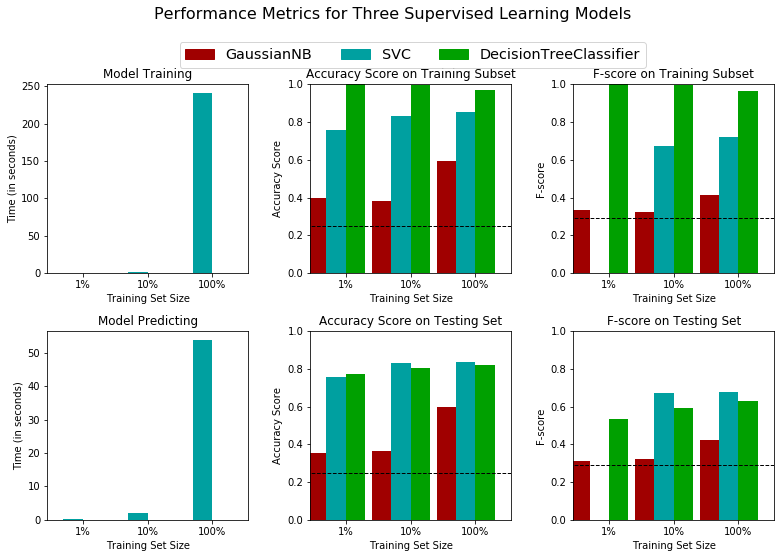

In [25]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = SVC(kernel = 'rbf')

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

我们来分析一下结果，结果分为六组图片，上面三组代表在训练集的表现，下面三组代表在测试集的表现。从左到右分别是测试时间，准确率，f-beta得分。   
先来分析运行时间，很明显SVC无论在测试集还是在训练集都是非常消耗时间的，我们发现，SVC对训练集数据规模比较敏感，当数据集规模增加90%时，svc的运行时间增加了200倍。   
再看不同的模型在测试集和训练集上的准确率表现，首先，在训练集，无论数据规模大小，决策树性能优于SVC优于朴素贝叶斯且均优于我们的朴素分类器。然后在测试集上，SVC的性能表现超越了决策树，这也是之前在模型选择时我们提到的，决策树容易产生过拟合，而svc的泛化能力较强。使用f-bata得分作为测量标准也发生了同样的情况。

## 4. 改进结果

### 4.1 选择最好的模型

接下来需要考虑的是，哪个模型更加适合我们的数据集，很明显，从运行时时间，准确率和泛化能力来看，决策树是更优的选择。

### 4.2 模型参数调优

既然已经选定了模型，接下来就是调参数，优化模型。我们使用的方法是传统的网格搜索（grid search），也就是设定不同的参数值，通过不断的试验，得到表现最好的模型。

In [27]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'max_depth':(2,3,4,5,6), 'criterion': ['gini','entropy']}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8186
F-score on testing data: 0.6279

Optimized Model
------
Final accuracy score on the testing data: 0.8523
Final F-score on the testing data: 0.7224


这里我们使用的核心函数就是`GridSearchCV`,该参数有三个输入，分别是分类器，参数和测量指标，其中测量标准需要使用`make_scorer(fbeta_score, beta=0.5)`来生成，参数的话使用字典数据类型来表示不同的参数及其取值。

通过测试，我们得到了更好的模型参数，模型的性能得到了提升！

## 5. 特征重要性

通常来说，不是所有的特征对模型性能都有同样的重要性，一般来说，一部分关键特征决定了模型的大部分性能。

### 5.1 提取特征的重要性

在`scikit-learn`库中，部分机器学习算法具有`.feature_importances_`属性,通过该属性，我们既可以得到影响算法性能的关键特征。我们以AdaBoost模型为例：

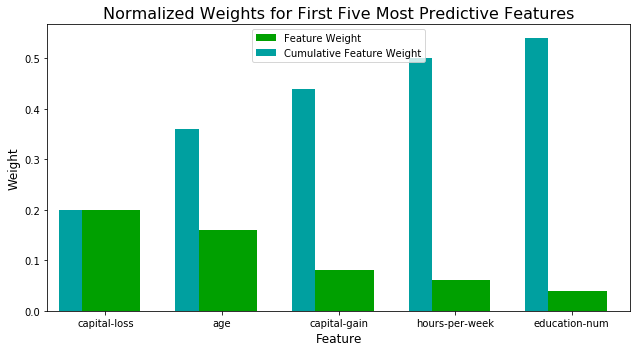

In [28]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

这里展示了前5个影响最大的特征及其影响权重。

## 6. 特征选择

最后，我们来看一下，如果仅使用最有影响力的5个特征进行训练，得到什么结果。

In [29]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8523
F-score on testing data: 0.7224

Final Model trained on reduced data
------
Accuracy on testing data: 0.8278
F-score on testing data: 0.6587


结果是，模型性能下降了，但是下降的不多，也就是说，如果仅使用5个特征值而不是13个，能得到接近的性能，大大提升了效率！

## 总结

最后，通过这个案例，我们总结一下机器学习算法性能比对分析流程：

1. 探索数据：了解数据的基本情况
2. 准备数据：对数据进行清洗，正则化等
3. 评估模型性能：根据经验选择比较适合模型以及测量标准进行比对分析
4. 改进结果：根据比对结果选择最好的模型，并对其进行调参
5. 特征选择：考虑使用影响力较大的部分特征